In [3]:
# text classification on tensorflow dataset from BigQuery

In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [5]:
! apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [6]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset =  tf.keras.utils.get_file("stackoverflow", url,
                                   untar=True, cache_dir='',
                                   cache_subdir='')

dataset_dir = os.path.dirname(dataset)

In [7]:
os.listdir(dataset_dir)

['stackoverflow.tar.gz', 'test', 'README.md', 'train']

In [8]:
! tree -d /tmp/.keras

/tmp/.keras
├── test
│   ├── csharp
│   ├── java
│   ├── javascript
│   └── python
└── train
    ├── csharp
    ├── java
    ├── javascript
    └── python

10 directories


In [9]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['python', 'csharp', 'javascript', 'java']

In [10]:
sample_file = os.path.join(train_dir , "java/1755.txt")
with open(sample_file) as f :
  print(f.read())

"http status 500 does not have the property 'id' i get error messsage when i display the id of the customer. i have too try to change the name of the property 'id' but the came the same error with new name...http status 500 - internal server error..type exception report.message internal server error.description the server encountered an internal error that prevented it from fulfilling this request...exception .org.apache.jasper.jasperexception: blankx.el.propertynotfoundexception: the class 'de.blank2enterprise.onlineshop.model.customer' does not have the property 'id'...root cause .blankx.el.propertynotfoundexception: the class 'de.blank2enterprise.onlineshop.model.customer' does not have the property 'id'...note the full stack traces of the exception and its root causes are available in the glassfish server open source edition 5.1.0 logs...html:....&lt;%@ include file=""header.jspf"" %&gt;..&lt;!doctype html&gt;.&lt;html&gt;. &lt;head&gt;.  &lt;meta charset=""utf-8""&gt;.  &lt;title&

In [11]:
## load the text files into a tf.data.Dataset object
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "/tmp/.keras/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset="training",
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("post", text_batch.numpy()[i])
    print("Label", raw_train_ds.class_names[label_batch.numpy()[i]])

post b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default construct

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "/tmp/.keras/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "/tmp/.keras/test",
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [15]:
# standardize
# tokenize
# vectorize

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("post", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

post tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extra 

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
# creating the model
embedding_dim = 16


In [25]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

In [27]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=["accuracy"])

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 29s 135ms/step - loss: 1.3776 - accuracy: 0.3320 - val_loss: 1.3651 - val_accuracy: 0.4831
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3471 - accuracy: 0.4677 - val_loss: 1.3250 - val_accuracy: 0.5381
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 1.2957 - accuracy: 0.5269 - val_loss: 1.2649 - val_accuracy: 0.5763
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 1.2253 - accuracy: 0.5770 - val_loss: 1.1925 - val_accuracy: 0.6231
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 1.1500 - accuracy: 0.6253 - val_loss: 1.1181 - val_accuracy: 0.6631
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0748 - accuracy: 0.6698 - val_loss: 1.0480 - val_accuracy: 0.6875
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0035 - accuracy: 0.7031 - val_loss: 0.9842 - val_accuracy: 0.7156
Epo

In [29]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 0.8661 - accuracy: 0.7318
Loss:  0.8661297559738159
Accuracy:  0.7317500114440918


In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

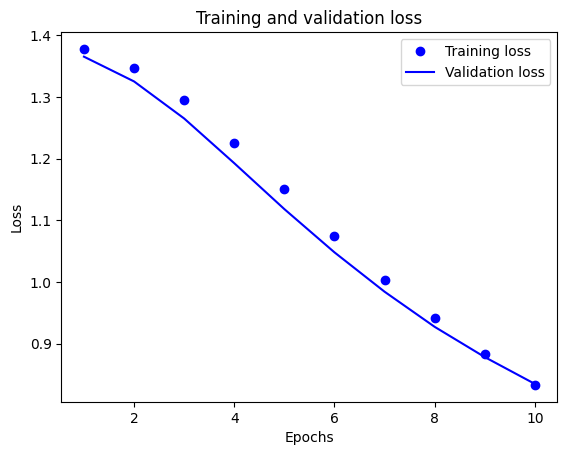

In [31]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

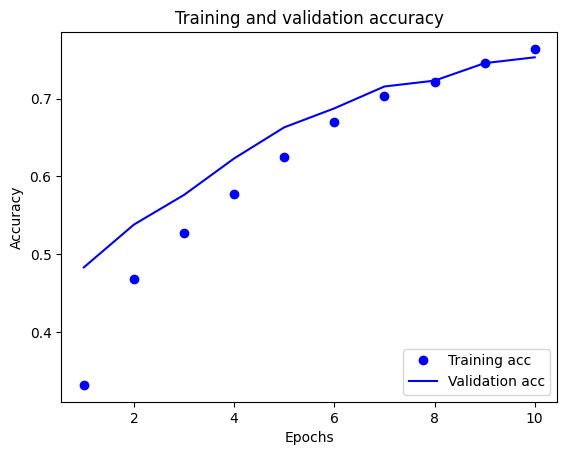

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()